In [5]:
import torch
import torchvision
from era_data import TabletPeriodDataset, get_IDS
from matplotlib import pyplot as plt
import pandas as pd  
import numpy as np
import seaborn as sns
from tqdm import tqdm

import warnings

# Ignore specific FutureWarnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='seaborn')


In [142]:
# IMG_DIR = 'output/images'
RUN_NAME_SUFFIX = '-masked' # ''
IMG_DIR = 'output/images_preprocessed'
LR = 5e-5
EPOCHS = 50
BATCH_SIZE = 16
SUFFIX = '-resnet50'

In [143]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [144]:
IDS = get_IDS(IMG_DIR=IMG_DIR)
len(IDS)

97640

In [145]:
VERNAME = 'period_clf_bs16_lr5e-05_15epochs-resnet50-97640_samples-masked-Sept_19_blur-early_stopping-1'
train_ids = pd.read_csv(f'output/clf_ids/period-train-{VERNAME}.csv', header=None)[0].astype(str)
test_ids = pd.read_csv(f'output/clf_ids/period-test-{VERNAME}.csv', header=None)[0].astype(str)

In [146]:
ds_train = TabletPeriodDataset(IDS=train_ids, IMG_DIR=IMG_DIR, mask=True)
ds_test = TabletPeriodDataset(IDS=test_ids, IMG_DIR=IMG_DIR, mask=True)

Filtering 97640 IDS down to provided 97140...
Filtering 97640 IDS down to provided 500...


In [147]:
import numpy as np
from scipy.ndimage import label
import cv2
# Your binary image as a NumPy array
# Convert the input image to binary (CV_8UC1)
def tablet_biggest_comp(binary_image):

    # Find connected components
    labeled_image, num_features = label(binary_image)

    # Calculate the sizes of the connected components
    component_sizes = np.bincount(labeled_image.ravel())

    # Find the label of the largest component (excluding background)
    largest_component_label = np.argmax(component_sizes[1:]) + 1

    # Create a mask for the largest component
    largest_component_mask = (labeled_image == largest_component_label)

    # Extract the largest component using the mask
    largest_component_image = binary_image * largest_component_mask

    return largest_component_image

def tablet_h_w_ratio(image):
    # Find contours in the binary image
    contours, _ = cv2.findContours(image.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour (object)
    largest_contour = max(contours, key=cv2.contourArea)

    # Calculate the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Calculate width and height
    width = w
    height = h
    return (h, w, round(height / width, 2))

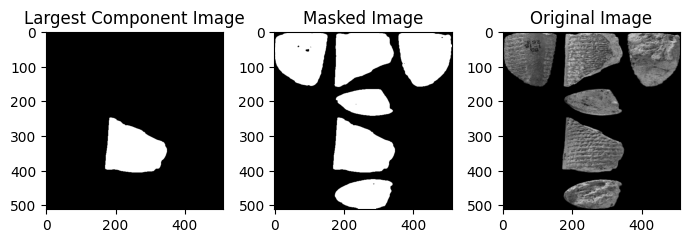

In [164]:
# Looking at the result of the image processing
from PIL import Image
id_img= 26596
plt.figure(figsize=(7, 5))
image = ds_train[id_img][0]
largest_component_image = tablet_biggest_comp(image)

plt.subplot(1, 3, 1)
plt.imshow(largest_component_image, cmap='gray')
plt.title('Largest Component Image')
ds_train.img_fns[36]
plt.subplot(1, 3, 2)
plt.imshow(image, cmap='gray')
plt.title('Masked Image')
plt.subplot(1, 3, 3)
plt.imshow(Image.open(ds_train.img_fns[id_img]), cmap='gray')
plt.title('Original Image')

plt.tight_layout()
plt.show()


In [74]:
# Print the calculated width and height
image = ds_train[id_img][0]
largest_component_image = tablet_biggest_comp(image)
print("Ratio (Height/Width):", tablet_h_w_ratio(largest_component_image))

Ratio (Height/Width): (191, 307, 0.62)


In [13]:
#looking at a df with the IDs and corresponding meta data

df_encodings = pd.read_csv('vae_encodings_and_data/vae_encoding_df_Oct2-v3_w_class_train.csv')

In [75]:
def group_concat(index_series):
    return index_series.tolist()

# Group all indexes on a period ({period_name:[indices list], ...})
result_df = df_encodings.reset_index().groupby('Period_Name')['index'].apply(group_concat) 

In [76]:
result_df

Period_Name
Achaemenid              [25675, 29576, 29669, 29809, 30053, 30055, 300...
ED I-II                 [21213, 21740, 22322, 22323, 22326, 32778, 331...
ED IIIa                 [17426, 21212, 22065, 22066, 22067, 22068, 220...
ED IIIb                 [5975, 15198, 19482, 19483, 19484, 19545, 1954...
Early Old Babylonian    [1579, 3484, 17483, 17489, 17490, 17491, 17492...
Ebla                    [22606, 22607, 22608, 22609, 22610, 22611, 226...
Hellenistic             [25648, 25752, 34115, 34616, 35827, 36364, 366...
Lagash II               [4074, 5131, 5132, 5133, 6443, 6906, 6907, 690...
Middle Assyrian         [29649, 30077, 31997, 32163, 32871, 41371, 447...
Middle Babylonian       [20673, 20675, 20677, 20678, 20680, 20681, 206...
Middle Elamite          [30333, 31987, 36292, 36293, 36294, 36295, 362...
Middle Hittite          [44484, 61621, 61622, 61623, 61624, 61625, 616...
Neo-Assyrian            [22347, 22348, 22349, 22350, 22351, 22352, 223...
Neo-Babylonian          [9

In [144]:
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.auto import tqdm

# Assuming ds_train, tablet_biggest_comp, and tablet_h_w_ratio are defined elsewhere

def calculate_ratio_and_extract_values(tablet_id):
    biggest_component = tablet_biggest_comp(ds_train[tablet_id][0])
    h, w, ratio = tablet_h_w_ratio(biggest_component)
    values = [ds_train[tablet_id][1], ds_train[tablet_id][2]]  # Extract additional values
    return {'tablet_id': tablet_id, 'height': h, 'width': w, 'hw_ratio': ratio, 'period': values[0], 'genre': values[1]}

# Function to execute in parallel
def process_tablet_id(tablet_id):
    return calculate_ratio_and_extract_values(tablet_id)

# Prepare to accumulate results
data = []

# Number of workers (threads); adjust based on your hardware
num_workers = 4

# Initialize ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=num_workers) as executor:
    # Create a list to hold the futures
    futures = [executor.submit(process_tablet_id, tablet_id) for tablet_id in df_encodings.index]
    
    # Initialize tqdm progress bar
    progress = tqdm(as_completed(futures), total=len(futures), desc='Processing Tablets')
    
    for future in progress:
        # As each future completes, append its result to the data list
        data.append(future.result())

# Convert the list of dictionaries to a DataFrame
ratio_df = pd.DataFrame(data)

# Print the resulting DataFrame
print(ratio_df)


Processing Tablets:   0%|          | 0/95088 [00:00<?, ?it/s]

       tablet_id  height  width  hw_ratio  period  genre
0              6     178    252      0.71       1      1
1              5     180    243      0.74       1      1
2              0     170    240      0.71       1      1
3              3     172    240      0.72       1      1
4              4     173    227      0.76       1      1
...          ...     ...    ...       ...     ...    ...
95083      95083     502    493      1.02       1      1
95084      95084     496    484      1.02       1      4
95085      95085     198    295      0.67       3      9
95086      95086     171    279      0.61       3      9
95087      95087     158    289      0.55      10      8

[95088 rows x 6 columns]


In [197]:
PERIOD_INDICES = {

    0: 'other',
    1: 'Ur III',
    2: 'Neo-Assyrian',
    3: 'Old Babylonian',
    4: 'Middle Babylonian',
    5: 'Neo-Babylonian',
    6: 'Old Akkadian',
    7: 'Achaemenid',
    8: 'Early Old Babylonian',
    9: 'ED IIIb',
    10: 'Middle Assyrian',
    11: 'Old Assyrian',
    12: 'Uruk III',
    13: 'Proto-Elamite',
    14: 'Lagash II',
    15: 'Ebla',
    16: 'ED IIIa',
    17: 'Hellenistic',
    18: 'ED I-II',
    19: 'Middle Elamite',
    20: 'Middle Hittite',
    21: 'Uruk IV'
}

GENRE_INDICES = {
        
        1: 'Administrative',
        2: 'Letter',
        3: 'Legal',
        4: 'Royal/Monumental',
        5: 'Literary',
        6: 'Lexical',
        7: 'Omen',
        8: 'uncertain',
        9: 'School',
        10: 'Mathematical',
        11: 'Prayer/Incantation',
        12: 'Scientific',
        13: 'Ritual',
        14: 'fake (modern)',
        15: 'Astronomical',
        16: 'Private/Votive',
    }

ratio_df['Period_Name'] = ratio_df['period'].map(PERIOD_INDICES)
ratio_df['Genre_Name'] = ratio_df['genre'].map(GENRE_INDICES)

In [148]:
ratio_df

,tablet_id,height,width,hw_ratio,period,genre,Period_Name,Geriod_Name
0,6,178,252,0.71,1,1,Ur III,Administrative
1,5,180,243,0.74,1,1,Ur III,Administrative
2,0,170,240,0.71,1,1,Ur III,Administrative
3,3,172,240,0.72,1,1,Ur III,Administrative
4,4,173,227,0.76,1,1,Ur III,Administrative
...,...,...,...,...,...,...,...,...
95083,95083,502,493,1.02,1,1,Ur III,Administrative
95084,95084,496,484,1.02,1,4,Ur III,Royal/Monumental
95085,95085,198,295,0.67,3,9,Old Babylonian,School
95086,95086,171,279,0.61,3,9,Old Babylonian,School


In [74]:
def period_to_millennium(period):
    if period in ['Uruk III', 'Uruk IV', 'Proto-Elamite', 'ED I-II', 'ED IIIa', 'ED IIIb', 'Ebla', 'Old Akkadian', 'Lagash II', 
                                                                         'Ur III']:
        return "1st millennium BCE"
    elif period in ['Early Old Babylonian', 'Old Babylonian', 'Old Assyrian', 'Middle Assyrian', 
                                                                        'Middle Babylonian', 'Middle Elamite', 'Middle Hittite']:
        return "2nd millennium BCE"
    else:
        return "3rd millennium BCE"

# Apply the function to the 'period' column to create a new 'millennium' column
ratio_df['millennium'] = ratio_df['Period_Name'].apply(period_to_millennium)


In [75]:
ratio_df.to_csv('output/ratio_df.csv', index = False) 

In [6]:
ratio_df = pd.read_csv('output/ratio_df.csv')

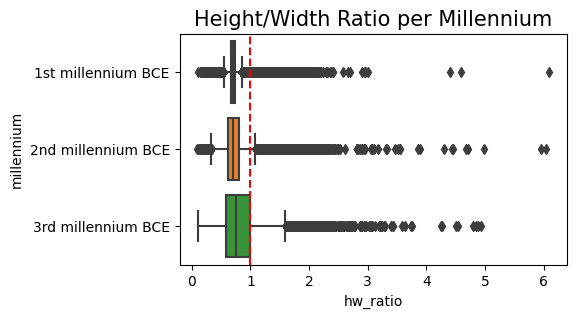

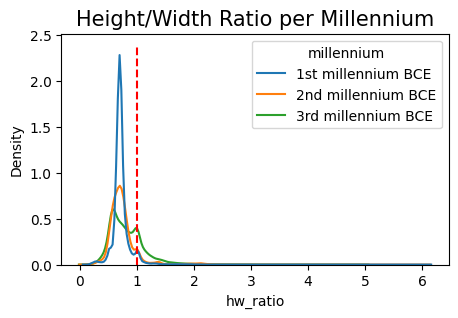

In [7]:
plt.figure(figsize=(5, 3))
box_p = sns.boxplot(y = 'millennium', x = 'hw_ratio', data = ratio_df)
left, right = plt.ylim()
plt.vlines([1], ymin=left, ymax=right, color='r', linestyles='--')
plt.yticks(fontsize=10)
plt.title('Height/Width Ratio per Millennium', size=15);
plt.show() 

plt.figure(figsize=(5, 3))
dist_p = sns.kdeplot(hue = 'millennium', x = 'hw_ratio', data = ratio_df)
left, right = plt.ylim()
plt.vlines([1], ymin=left, ymax=right, color='r', linestyles='--')
plt.yticks(fontsize=10)
plt.title('Height/Width Ratio per Millennium', size=15);

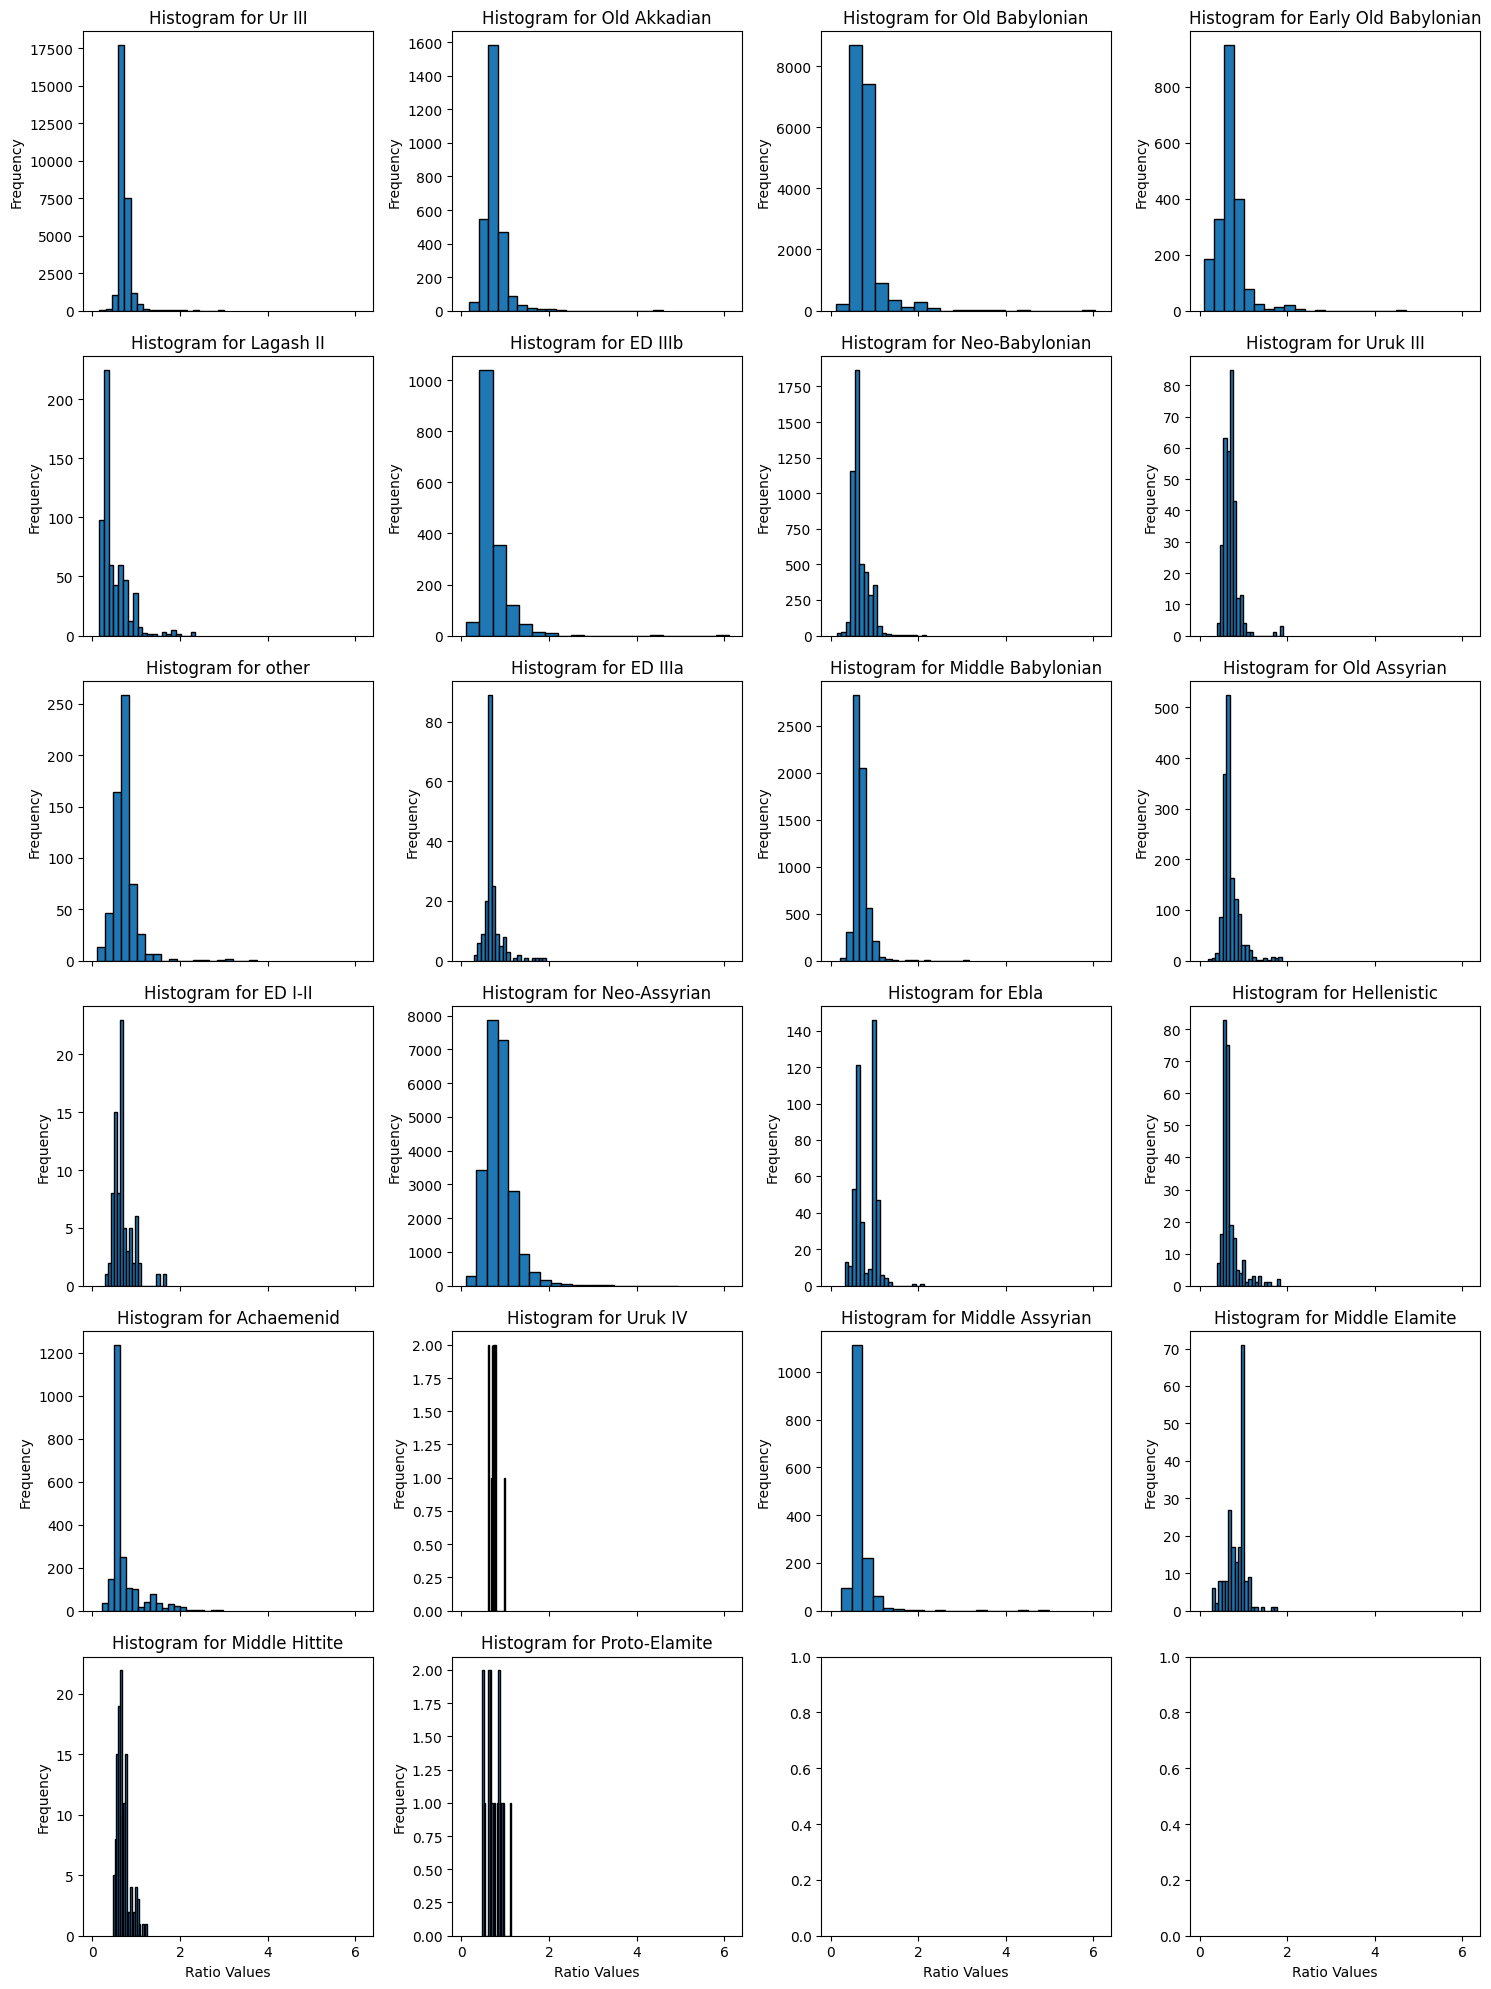

In [8]:
# Calculate the number of rows and columns for the grid
num_periods = ratio_df.period.nunique()
num_cols = 4  # You can adjust the number of columns as needed
num_rows = -(-num_periods // num_cols)  # Ceiling division

# Create a grid of subplots for histogram plots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 20), sharex=True)  # Add 'sharex=True'

# Iterate over each period and its corresponding ratio list
for idx, period in enumerate(ratio_df.Period_Name.unique()):
    row = idx // num_cols
    col = idx % num_cols
    period_df = ratio_df[ratio_df['Period_Name']==period]
    # Create histogram in the specified subplot
    axs[row, col].hist(period_df['hw_ratio'], bins=20, edgecolor='black')
    axs[row, col].set_title(f'Histogram for {period}')
    axs[row, col].set_ylabel('Frequency')

# Set a common x-axis label
for ax in axs[-1, :]:
    ax.set_xlabel('Ratio Values')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

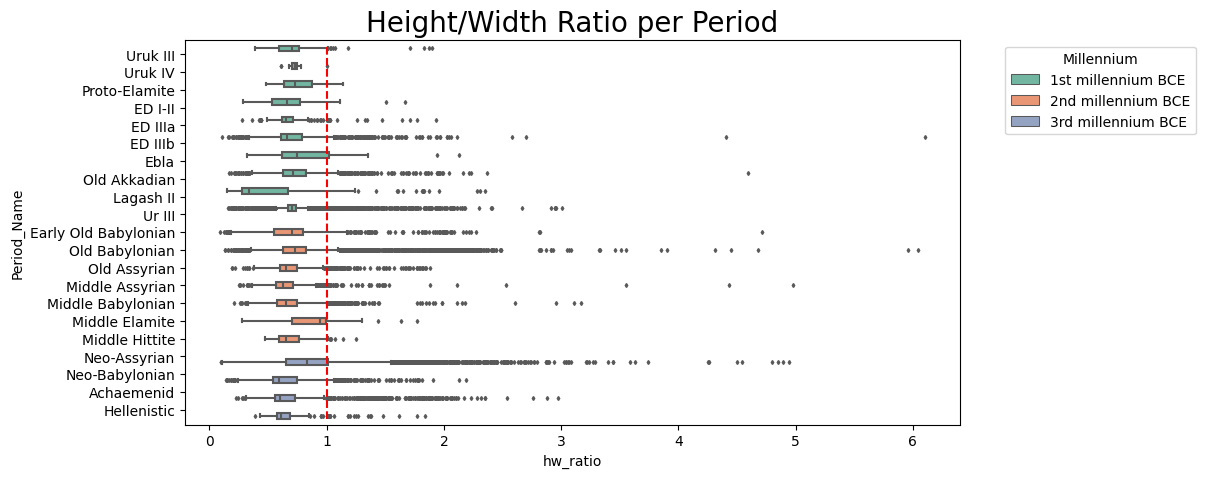

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))

period_order = ['Uruk III', 'Uruk IV', 'Proto-Elamite', 'ED I-II', 'ED IIIa', 'ED IIIb', 'Ebla', 'Old Akkadian', 'Lagash II', 
                'Ur III', 'Early Old Babylonian', 'Old Babylonian', 'Old Assyrian', 'Middle Assyrian', 
                'Middle Babylonian', 'Middle Elamite', 'Middle Hittite', 'Neo-Assyrian', 
                'Neo-Babylonian', 'Achaemenid', 'Hellenistic']

period_index = {period: i for i, period in enumerate(period_order)}
ratio_df['Period_Index'] = ratio_df['Period_Name'].map(period_index)

box_p = sns.boxplot(y='Period_Name', x='hw_ratio', data=ratio_df, hue='millennium',
                    order=period_order, palette="Set2", width=1, fliersize=2)

left, right = plt.ylim()
plt.vlines([1], ymin=left, ymax=right, color='r', linestyles='--')
plt.title('Height/Width Ratio per Period', size=20)
plt.legend(title='Millennium', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


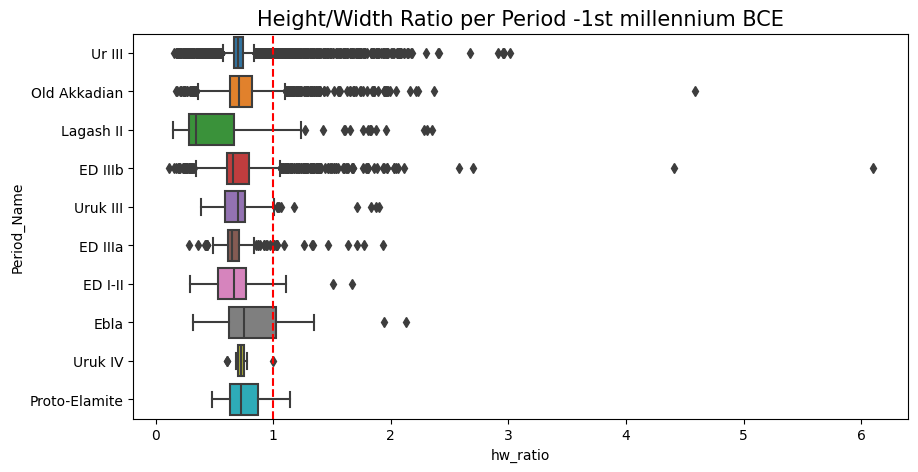

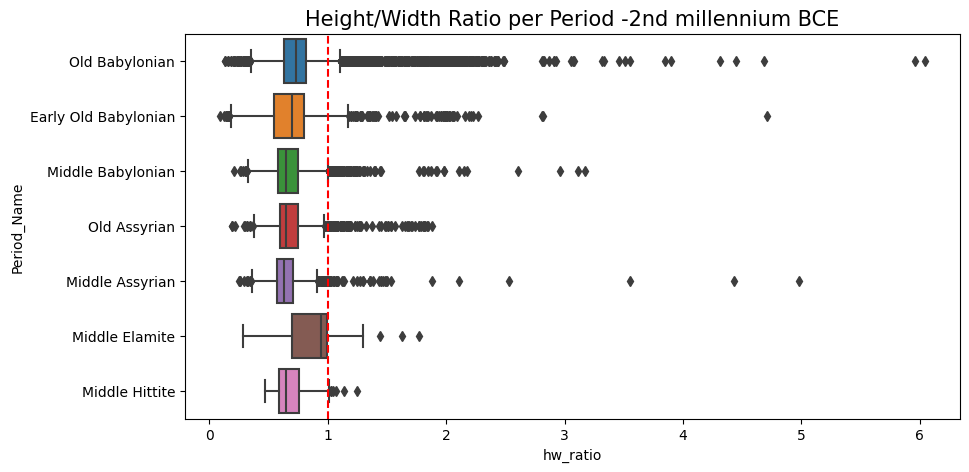

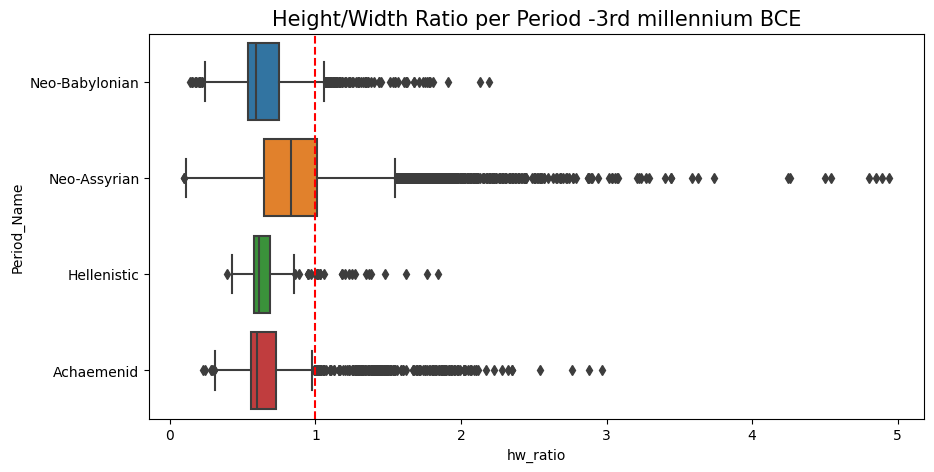

In [10]:
for millennium in ratio_df["millennium"].unique():
    plt.figure(figsize=(10, 5))
    box_p = sns.boxplot(y = 'Period_Name', x = 'hw_ratio', data = ratio_df[(ratio_df["millennium"]==millennium)&(ratio_df["Period_Name"]!='other')])
    left, right = plt.ylim()
    plt.vlines([1], ymin=left, ymax=right, color='r', linestyles='--')
    plt.yticks(fontsize=10)
    plt.title('Height/Width Ratio per Period -' + millennium, size=15);

In [11]:
ratio_df[['height', 'width','Genre_Name']].groupby('Genre_Name').corr().unstack().iloc[:,1].sort_values()

Genre_Name
Private/Votive        0.169591
School                0.480686
Legal                 0.512676
Mathematical          0.546108
Administrative        0.616249
Letter                0.623722
Literary              0.628121
Prayer/Incantation    0.660137
Scientific            0.715397
Astronomical          0.720802
Lexical               0.724056
Royal/Monumental      0.733868
Omen                  0.752603
uncertain             0.753351
Ritual                0.812453
fake (modern)         0.814119
Name: (height, width), dtype: float64

In [12]:
ratio_df[['height', 'width','Period_Name']].groupby('Period_Name').corr().unstack().iloc[:,1].sort_values()

Period_Name
Old Assyrian            0.360206
Lagash II               0.399404
Uruk III                0.450922
Old Babylonian          0.549135
Achaemenid              0.550621
ED IIIb                 0.551857
Middle Babylonian       0.565193
Proto-Elamite           0.566315
ED IIIa                 0.583902
other                   0.609339
Old Akkadian            0.629533
Middle Assyrian         0.631909
Early Old Babylonian    0.641039
Hellenistic             0.649425
Ur III                  0.662545
Middle Hittite          0.725524
Neo-Babylonian          0.748334
Neo-Assyrian            0.774219
ED I-II                 0.824579
Middle Elamite          0.861091
Ebla                    0.889148
Uruk IV                 0.974716
Name: (height, width), dtype: float64

In [13]:
ratio_df[ratio_df['millennium']=='1st millennium BCE'][['height', 'width']].corr()

,height,width
height,1.000000,0.660794
width,0.660794,1.000000


In [14]:
ratio_df[ratio_df['millennium']=='2nd millennium BCE'][['height', 'width']].corr()

,height,width
height,1.000000,0.568097
width,0.568097,1.000000


In [15]:
ratio_df[(ratio_df['millennium']=='3rd millennium BCE')&(ratio_df['period']!="other")][['height', 'width']].corr()

,height,width
height,1.000000,0.748443
width,0.748443,1.000000


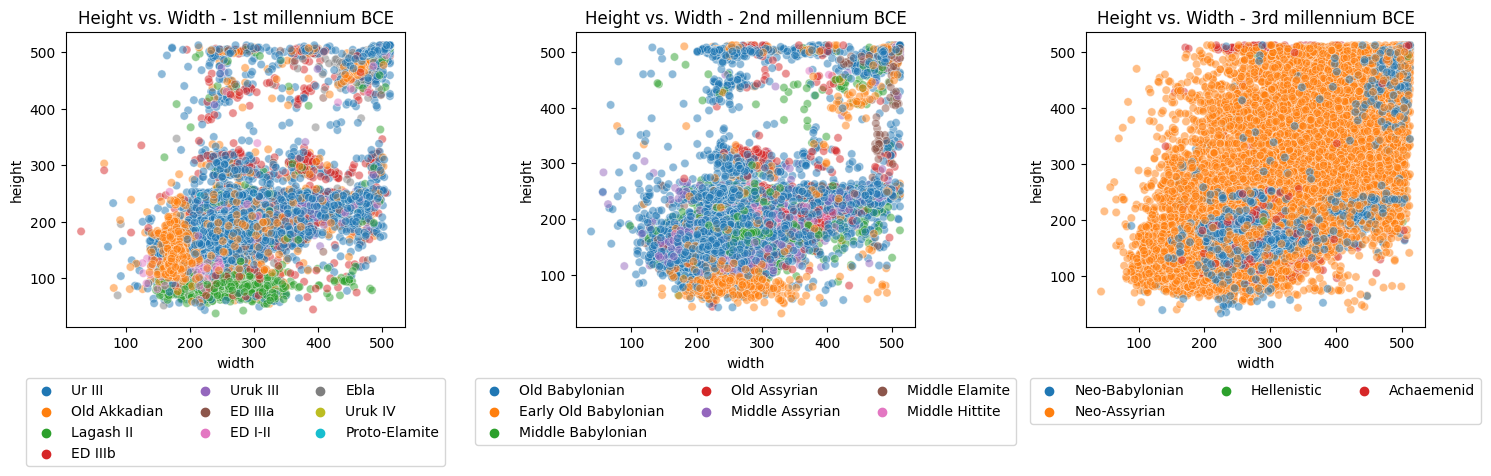

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

unique_millenniums = ratio_df[ratio_df["Period_Name"] != 'other']["millennium"].unique()

fig, axes = plt.subplots(1, len(unique_millenniums), figsize=(15, 5))  # Adjust the figsize based on the number of millenniums

for i, millennium in enumerate(unique_millenniums):
    ax = axes[i]
    plot = sns.scatterplot(x='width', y='height', hue='Period_Name', 
                    data=ratio_df[(ratio_df["millennium"] == millennium) & (ratio_df["Period_Name"] != 'other')],
                    alpha=0.5, ax=ax)
    
    ax.set_title("Height vs. Width - " + millennium)

    # Place a legend below each subplot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# Adjust the layout
plt.tight_layout()

plt.show()


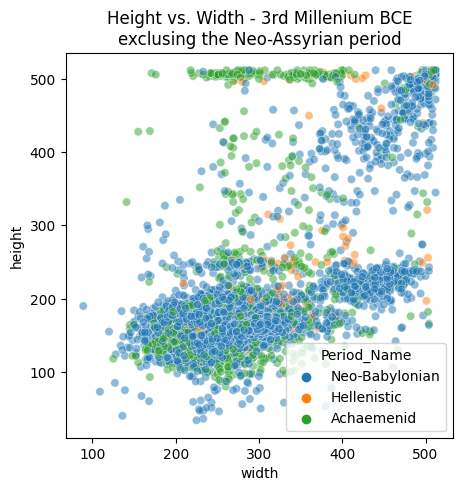

In [17]:
plt.figure(figsize=(5, 5))
sns.scatterplot(y='height', x ='width', hue='Period_Name', data=ratio_df[(ratio_df["millennium"]=='3rd millennium BCE')&~(ratio_df["Period_Name"].isin(['other', 'Neo-Assyrian']))], alpha = 0.5)
plt.title("Height vs. Width - 3rd Millenium BCE\nexclusing the Neo-Assyrian period")
plt.show()

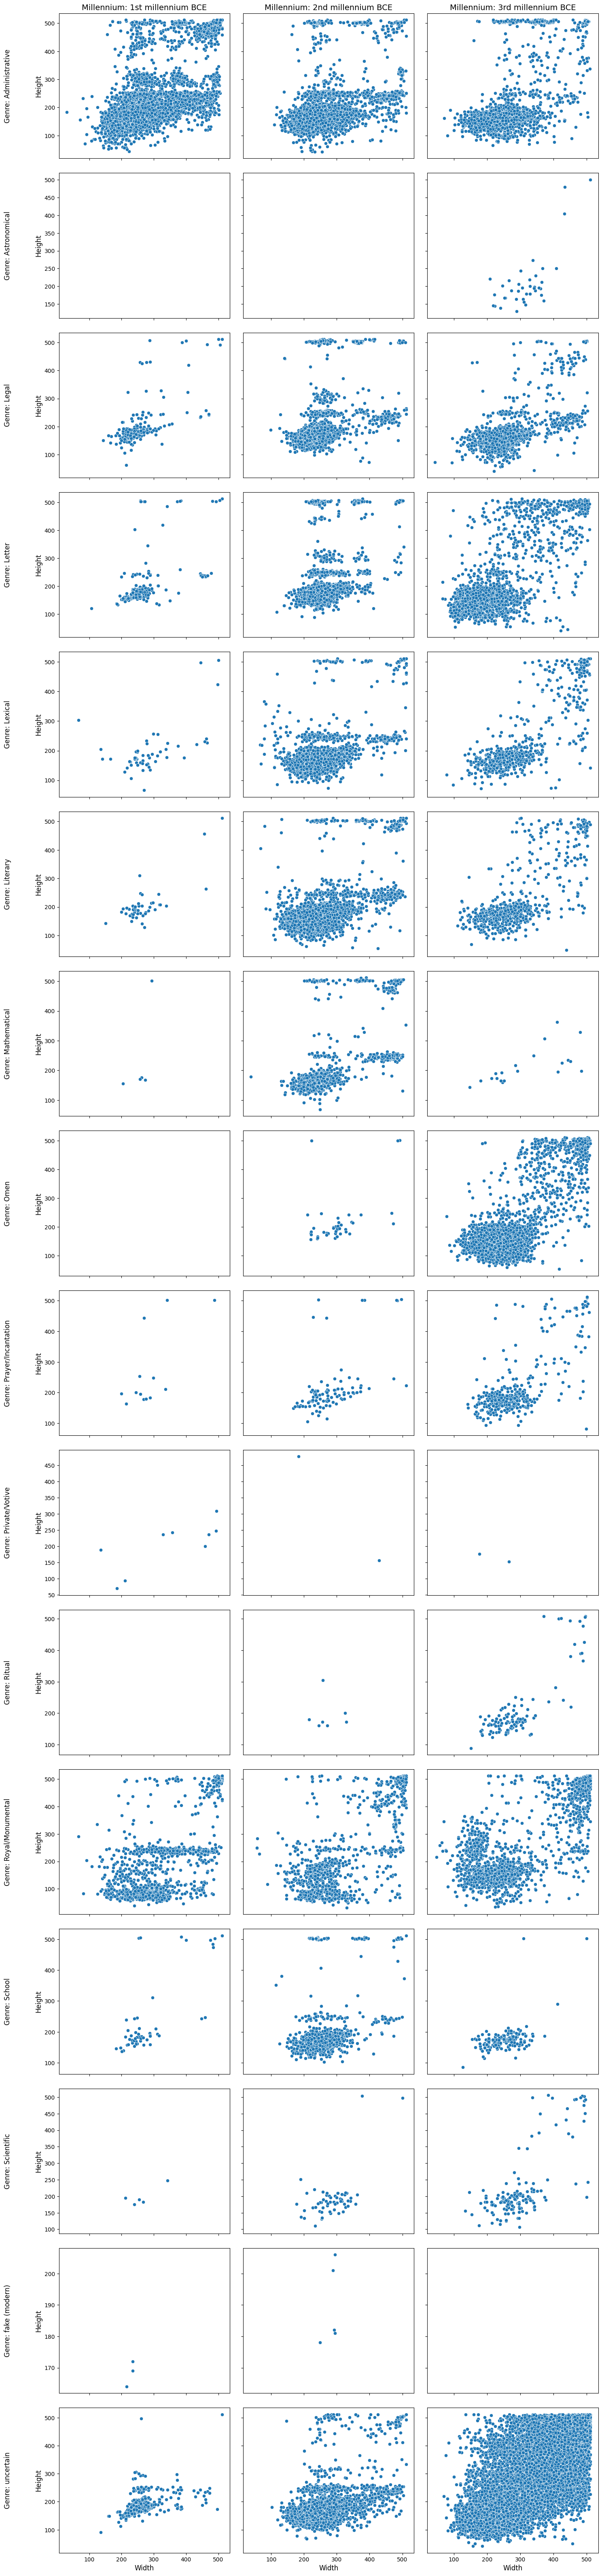

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

max_cols = 3  # One column for each millennium

# Get the unique genres and sort them for consistent ordering
unique_genres = sorted(ratio_df["Genre_Name"].unique())

# Number of rows is equal to the number of unique genres
n_rows = len(unique_genres)

# Adjust the figure size to decrease plot sizes
fig_width = max_cols * 5  # Decrease width for smaller plots
fig_height = n_rows * 4  # Decrease height accordingly
fig, axes = plt.subplots(n_rows, max_cols, figsize=(fig_width, fig_height), sharex='col', sharey='row')

# Ensure axes is a 2D array even if there's only one row
if n_rows == 1:
    axes = np.array([axes])

# Labeling and plotting for each subplot
for i, genre in enumerate(unique_genres):
    for j, millennium in enumerate(sorted(ratio_df["millennium"].unique())):
        ax = axes[i, j]
        df_filtered = ratio_df[(ratio_df["millennium"] == millennium) & (ratio_df["Genre_Name"] == genre)]
        
        sns.scatterplot(x='width', y='height', data=df_filtered, ax=ax)
        
        if i == 0:
            ax.set_title(f'Millennium: {millennium}', fontsize=14)
        if j == 0:
            ax.text(-0.3, 0.5, f'Genre: {genre}', fontsize=12, rotation=90,
                    ha='center', va='center', transform=ax.transAxes)

        if i == n_rows - 1:
            ax.set_xlabel('Width', fontsize=12)
        if j == 0:
            ax.set_ylabel('Height', fontsize=12)

plt.tight_layout(pad=2.0)

plt.show()


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [42]:
X_train, X_test, y_train, y_test = train_test_split(ratio_df[['hw_ratio']], ratio_df['period'], test_size=500)
print(X_train.shape, X_test.shape)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

(94588, 1) (500, 1)


In [43]:
print(classification_report(y_test, preds))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.48      0.76      0.59       154
           2       0.44      0.57      0.50       120
           3       0.29      0.22      0.25        96
           4       0.00      0.00      0.00        34
           5       0.17      0.15      0.16        26
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         8
          11       0.00      0.00      0.00         7
          14       0.40      0.50      0.44         4
          15       0.00      0.00      0.00         3
          16       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         2
          19       0.00      0.00      0.00         1
          20       0.00    

/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [44]:
EARLY_BRONZE = {
    'Old Akkadian', 'Ur III',
    'ED IIIb', 'Uruk III',
    'Proto-Elamite', 'Lagash II',
    'Ebla', 'ED IIIa', 'ED I-II',
    'Uruk IV', 'Linear Elamite',
    'Harappan'
}
MID_LATE_BRONZE = {
    'Early Old Babylonian',
    'Old Babylonian', 'Old Assyrian',
    'Middle Babylonian', 'Middle Assyrian',
    'Middle Elamite', 'Middle Hittite'
}
IRON = {
    'Neo-Babylonian', 'Neo-Assyrian',
    'Achaemenid', 'Hellenistic',
    'Neo-Elamite'
}
ERA_MAP = {
    **{K: 'EB' for K in EARLY_BRONZE},
    **{K: 'MLB' for K in MID_LATE_BRONZE},
    **{K: 'I' for K in IRON},
}

In [45]:
def explain(period):
    return f'{period} ({ERA_MAP.get(period, "?")})'

In [46]:
idx2period = {v: k for k, v in TabletPeriodDataset.PERIOD_INDICES.items()}
idx2period[0] = 'other'

In [47]:
from collections import Counter
# let's just use classes with support >=10, everything else goes to 0: other
COMMON_LABELS = list({k for k, v in Counter(y_test).items() if v >= 10})
print(f'Common labels: ({len(COMMON_LABELS)})')
[(i, explain(idx2period[i])) for i in COMMON_LABELS]

Common labels: (7)


[(1, 'Ur III (EB)'),
 (2, 'Neo-Assyrian (I)'),
 (3, 'Old Babylonian (MLB)'),
 (4, 'Middle Babylonian (MLB)'),
 (5, 'Neo-Babylonian (I)'),
 (6, 'Old Akkadian (EB)'),
 (8, 'Early Old Babylonian (MLB)')]

In [48]:
y_true_c = y_test.copy()
y_true_c[~np.isin(y_test, COMMON_LABELS)] = 0
print((~np.isin(y_test, COMMON_LABELS)).mean(), 'changed to "other"')

0.088 changed to "other"


In [49]:
y_pred_c = preds.copy()
y_pred_c[~np.isin(preds, COMMON_LABELS)] = 0
print((~np.isin(preds, COMMON_LABELS)).mean(), 'changed to "other"')

0.01 changed to "other"


In [50]:
indices_c = list(set(y_true_c) | set(y_pred_c))
print(len(indices_c))
print(indices_c)
PERIOD_LABELS_C = [explain(idx2period[i]) for i in indices_c]
print(PERIOD_LABELS_C)

8
[0, 1, 2, 3, 4, 5, 6, 8]
['other (?)', 'Ur III (EB)', 'Neo-Assyrian (I)', 'Old Babylonian (MLB)', 'Middle Babylonian (MLB)', 'Neo-Babylonian (I)', 'Old Akkadian (EB)', 'Early Old Babylonian (MLB)']


In [51]:
print(classification_report(y_true_c, y_pred_c, target_names=PERIOD_LABELS_C))

                            precision    recall  f1-score   support

                 other (?)       0.40      0.05      0.08        44
               Ur III (EB)       0.48      0.76      0.59       154
          Neo-Assyrian (I)       0.44      0.57      0.50       120
      Old Babylonian (MLB)       0.29      0.22      0.25        96
   Middle Babylonian (MLB)       0.00      0.00      0.00        34
        Neo-Babylonian (I)       0.17      0.15      0.16        26
         Old Akkadian (EB)       0.00      0.00      0.00        14
Early Old Babylonian (MLB)       0.00      0.00      0.00        12

                  accuracy                           0.43       500
                 macro avg       0.22      0.22      0.20       500
              weighted avg       0.35      0.43      0.36       500



/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le